In [213]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

from catboost import Pool, CatBoostRegressor, cv

%matplotlib inline

In [356]:
apartments = pd.read_csv('Train.csv')

In [193]:
# apartments.head(10)

In [194]:
# apartments.dtypes

In [260]:
# apartments.info()

In [263]:
# apartments.describe()

In [357]:
if any(apartments.columns.isin(['date'])):
    apartments.drop(['date'], axis=1, inplace=True)
    
apartments['g_lift'] = apartments['g_lift'].fillna(apartments['g_lift'].min())
apartments['metro_dist'] = apartments['metro_dist'].fillna(apartments['metro_dist'].max())
apartments['build_tech'] = apartments['build_tech'].fillna(10*apartments['build_tech'].max())
apartments.drop(apartments[apartments['price']==int(1e6)].index, inplace=True)

apartments['sqrt_area'] = apartments['area']**0.5
apartments['sqrt_rooms'] = apartments['rooms']**0.5
apartments['sqrt_metro_dist'] = apartments['metro_dist']**0.5

apartments['|mean_price - price|'] = np.abs(apartments['price'].mean()-apartments['price'])
apartments['weight'] = 1 - apartments['|mean_price - price|'] / apartments['|mean_price - price|'].max()

X_w = apartments.drop(['id', 'price', 'n_photos', '|mean_price - price|'], axis=1)
X = X_w.drop(['weight'], axis=1)
y = apartments.price

In [313]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95998 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   street_id             95998 non-null  int64  
 1   build_tech            95998 non-null  float64
 2   floor                 95998 non-null  int64  
 3   area                  95998 non-null  int64  
 4   rooms                 95998 non-null  int64  
 5   balcon                95998 non-null  int64  
 6   metro_dist            95998 non-null  float64
 7   g_lift                95998 non-null  float64
 8   kw1                   95998 non-null  int64  
 9   kw2                   95998 non-null  int64  
 10  kw3                   95998 non-null  int64  
 11  kw4                   95998 non-null  int64  
 12  kw5                   95998 non-null  int64  
 13  kw6                   95998 non-null  int64  
 14  kw7                   95998 non-null  int64  
 15  kw8                

<function matplotlib.pyplot.show(close=None, block=None)>

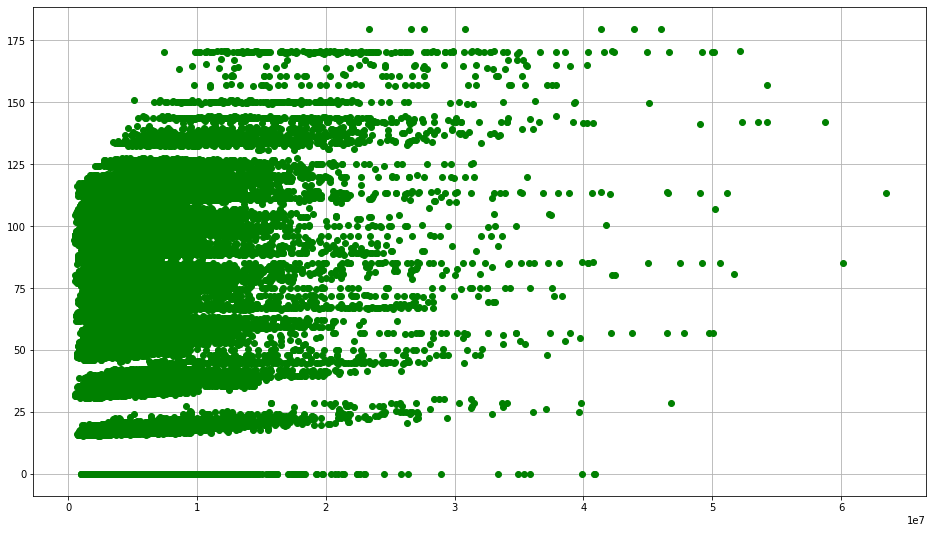

In [314]:
fig = plt.figure(figsize=(16, 9))
plt.plot(apartments['price'], apartments['sqrt_metro_dist_area'], 'go')
plt.grid(axis='both')
plt.show

In [171]:
def print_metrics(y_test, ans):
    print("MAE :", np.round(mean_absolute_error(y_test, ans), 4))

In [358]:
train_pool = Pool(X, 
                  y,
                  weight=X_w['weight'],
                  cat_features=[0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
test_pool = Pool(X, 
                 cat_features=[0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

In [216]:
params = {"iterations": 1000,
          "depth": 10,
          "loss_function": "MAE",
          "verbose": False}

scores = cv(train_pool,
            params,
            fold_count=5,
            plot='True'
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [294]:
model = CatBoostRegressor(loss_function='MAE')

grid = {'iterations': [int(x) for x in np.linspace(100, 1000, 91)],
        'learning_rate': [x for x in np.linspace(0.01, 1, 100)],
        'depth': [int(x) for x in np.linspace(2, 55, 54)],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X,
                                                   y=y,
                                                   cv=5,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3327119.4184628	test: 3281782.8944180	best: 3281782.8944180 (0)	total: 25.1ms	remaining: 10.8s
1:	learn: 2452748.6800612	test: 2409384.1073935	best: 2409384.1073935 (1)	total: 34.5ms	remaining: 7.39s
2:	learn: 2022844.7451746	test: 1986274.9131531	best: 1986274.9131531 (2)	total: 43.4ms	remaining: 6.18s
3:	learn: 1784235.7350688	test: 1758028.6486484	best: 1758028.6486484 (3)	total: 51.5ms	remaining: 5.48s
4:	learn: 1684770.6550140	test: 1663292.9657305	best: 1663292.9657305 (4)	total: 59.4ms	remaining: 5.05s
5:	learn: 1652647.5551024	test: 1634989.9903657	best: 1634989.9903657 (5)	total: 67.7ms	remaining: 4.78s
6:	learn: 1611766.1891372	test: 1597174.4370804	best: 1597174.4370804 (6)	total: 77ms	remaining: 4.65s
7:	learn: 1596614.1469966	test: 1582502.4008823	best: 1582502.4008823 (7)	total: 86.1ms	remaining: 4.54s
8:	learn: 1585741.5440645	test: 1574291.4748999	best: 1574291.4748999 (8)	total: 95ms	remaining: 4.44s
9:	learn: 1572736.7974593	test: 1562964.9153111	best: 15629

80:	learn: 1337377.9557028	test: 1337974.6657620	best: 1337974.6657620 (80)	total: 766ms	remaining: 3.3s
81:	learn: 1336359.9376009	test: 1337031.6321460	best: 1337031.6321460 (81)	total: 775ms	remaining: 3.29s
82:	learn: 1335011.7729369	test: 1335666.1088401	best: 1335666.1088401 (82)	total: 784ms	remaining: 3.28s
83:	learn: 1333277.5737009	test: 1334376.7937757	best: 1334376.7937757 (83)	total: 793ms	remaining: 3.27s
84:	learn: 1331892.3847005	test: 1333146.2732890	best: 1333146.2732890 (84)	total: 803ms	remaining: 3.26s
85:	learn: 1330823.4784677	test: 1332388.9100644	best: 1332388.9100644 (85)	total: 812ms	remaining: 3.25s
86:	learn: 1327918.3037190	test: 1328806.0421404	best: 1328806.0421404 (86)	total: 822ms	remaining: 3.24s
87:	learn: 1325059.5304460	test: 1326839.6797870	best: 1326839.6797870 (87)	total: 831ms	remaining: 3.23s
88:	learn: 1322500.3299375	test: 1324958.7693412	best: 1324958.7693412 (88)	total: 840ms	remaining: 3.22s
89:	learn: 1320645.9655238	test: 1323153.754423

160:	learn: 1229465.1280694	test: 1241188.5823129	best: 1241188.5823129 (160)	total: 1.5s	remaining: 2.5s
161:	learn: 1229312.8417064	test: 1241158.1603339	best: 1241158.1603339 (161)	total: 1.5s	remaining: 2.49s
162:	learn: 1228682.2383397	test: 1240786.9920418	best: 1240786.9920418 (162)	total: 1.51s	remaining: 2.48s
163:	learn: 1227875.0307528	test: 1240094.4157022	best: 1240094.4157022 (163)	total: 1.52s	remaining: 2.47s
164:	learn: 1227668.2942288	test: 1239900.0071648	best: 1239900.0071648 (164)	total: 1.53s	remaining: 2.46s
165:	learn: 1226970.5109660	test: 1239423.5227536	best: 1239423.5227536 (165)	total: 1.54s	remaining: 2.45s
166:	learn: 1226683.7524960	test: 1239219.5407314	best: 1239219.5407314 (166)	total: 1.55s	remaining: 2.44s
167:	learn: 1226532.9449127	test: 1239343.9409955	best: 1239219.5407314 (166)	total: 1.56s	remaining: 2.43s
168:	learn: 1226112.9229641	test: 1239061.9944469	best: 1239061.9944469 (168)	total: 1.57s	remaining: 2.42s
169:	learn: 1224662.6845675	tes

240:	learn: 1173596.1004898	test: 1196616.1986661	best: 1196433.6106566 (238)	total: 2.23s	remaining: 1.75s
241:	learn: 1173312.1401197	test: 1196349.9325959	best: 1196349.9325959 (241)	total: 2.24s	remaining: 1.74s
242:	learn: 1173037.5026490	test: 1196328.5362572	best: 1196328.5362572 (242)	total: 2.25s	remaining: 1.73s
243:	learn: 1172730.5080166	test: 1196099.3188284	best: 1196099.3188284 (243)	total: 2.25s	remaining: 1.72s
244:	learn: 1172628.8733868	test: 1196102.0938716	best: 1196099.3188284 (243)	total: 2.26s	remaining: 1.71s
245:	learn: 1172368.6156258	test: 1196285.3126572	best: 1196099.3188284 (243)	total: 2.27s	remaining: 1.7s
246:	learn: 1171636.0426338	test: 1195577.0643716	best: 1195577.0643716 (246)	total: 2.28s	remaining: 1.69s
247:	learn: 1170607.9099099	test: 1194817.0814114	best: 1194817.0814114 (247)	total: 2.29s	remaining: 1.68s
248:	learn: 1170445.7962718	test: 1194779.6760717	best: 1194779.6760717 (248)	total: 2.3s	remaining: 1.67s
249:	learn: 1168550.9080346	te

322:	learn: 1133358.6726178	test: 1163843.7842655	best: 1163843.7842655 (322)	total: 2.97s	remaining: 984ms
323:	learn: 1132872.0626850	test: 1163226.1592876	best: 1163226.1592876 (323)	total: 2.98s	remaining: 975ms
324:	learn: 1132536.3316222	test: 1162873.6277183	best: 1162873.6277183 (324)	total: 2.99s	remaining: 966ms
325:	learn: 1132276.7065288	test: 1162724.2274164	best: 1162724.2274164 (325)	total: 3s	remaining: 957ms
326:	learn: 1132067.6802009	test: 1162851.8669707	best: 1162724.2274164 (325)	total: 3.01s	remaining: 947ms
327:	learn: 1131798.0475729	test: 1162921.8654153	best: 1162724.2274164 (325)	total: 3.02s	remaining: 938ms
328:	learn: 1131348.4303396	test: 1162285.7467496	best: 1162285.7467496 (328)	total: 3.02s	remaining: 929ms
329:	learn: 1130754.9532526	test: 1161868.2055278	best: 1161868.2055278 (329)	total: 3.03s	remaining: 920ms
330:	learn: 1130691.3367266	test: 1161874.9258797	best: 1161868.2055278 (329)	total: 3.04s	remaining: 910ms
331:	learn: 1130458.5734355	tes

404:	learn: 1102970.4182185	test: 1138001.9985163	best: 1137807.4964273 (402)	total: 3.71s	remaining: 229ms
405:	learn: 1102390.9144010	test: 1137543.4866827	best: 1137543.4866827 (405)	total: 3.71s	remaining: 220ms
406:	learn: 1102014.3762136	test: 1137390.3091494	best: 1137390.3091494 (406)	total: 3.72s	remaining: 210ms
407:	learn: 1101669.4307202	test: 1137030.2262880	best: 1137030.2262880 (407)	total: 3.73s	remaining: 201ms
408:	learn: 1101525.1186020	test: 1136988.9114884	best: 1136988.9114884 (408)	total: 3.74s	remaining: 192ms
409:	learn: 1101462.5135544	test: 1137010.7358896	best: 1136988.9114884 (408)	total: 3.75s	remaining: 183ms
410:	learn: 1100864.4641166	test: 1136278.5426750	best: 1136278.5426750 (410)	total: 3.76s	remaining: 174ms
411:	learn: 1100527.0924469	test: 1135813.6389154	best: 1135813.6389154 (411)	total: 3.77s	remaining: 165ms
412:	learn: 1100352.5804372	test: 1135932.1679202	best: 1135813.6389154 (411)	total: 3.78s	remaining: 155ms
413:	learn: 1100221.9192058	

50:	learn: 1282997.4064964	test: 1291245.0130242	best: 1291245.0130242 (50)	total: 510ms	remaining: 8.19s
51:	learn: 1281270.8671565	test: 1289859.8640735	best: 1289859.8640735 (51)	total: 519ms	remaining: 8.17s
52:	learn: 1278615.6089586	test: 1288139.6934542	best: 1288139.6934542 (52)	total: 529ms	remaining: 8.15s
53:	learn: 1275848.2798292	test: 1286053.8933476	best: 1286053.8933476 (53)	total: 538ms	remaining: 8.14s
54:	learn: 1274781.2237278	test: 1285740.9016296	best: 1285740.9016296 (54)	total: 547ms	remaining: 8.11s
55:	learn: 1270970.4459007	test: 1282583.9616800	best: 1282583.9616800 (55)	total: 557ms	remaining: 8.1s
56:	learn: 1264169.2824682	test: 1276941.4882900	best: 1276941.4882900 (56)	total: 567ms	remaining: 8.08s
57:	learn: 1261819.6519108	test: 1273645.8946535	best: 1273645.8946535 (57)	total: 577ms	remaining: 8.07s
58:	learn: 1255617.7317667	test: 1267943.3726436	best: 1267943.3726436 (58)	total: 586ms	remaining: 8.06s
59:	learn: 1251684.7238033	test: 1263767.843290

145:	learn: 1120794.4963609	test: 1162697.3839807	best: 1162697.3839807 (145)	total: 1.42s	remaining: 7.05s
146:	learn: 1120398.1231825	test: 1162563.3098956	best: 1162563.3098956 (146)	total: 1.43s	remaining: 7.04s
147:	learn: 1119266.0279164	test: 1161210.8613838	best: 1161210.8613838 (147)	total: 1.44s	remaining: 7.03s
148:	learn: 1119019.9660944	test: 1161154.5715188	best: 1161154.5715188 (148)	total: 1.45s	remaining: 7.02s
149:	learn: 1118286.6458288	test: 1160922.3149602	best: 1160922.3149602 (149)	total: 1.46s	remaining: 7s
150:	learn: 1116594.8569816	test: 1159320.0101070	best: 1159320.0101070 (150)	total: 1.47s	remaining: 6.99s
151:	learn: 1115369.6300980	test: 1158700.5279098	best: 1158700.5279098 (151)	total: 1.48s	remaining: 6.98s
152:	learn: 1115025.7178931	test: 1158905.4689966	best: 1158700.5279098 (151)	total: 1.49s	remaining: 6.97s
153:	learn: 1114594.9830699	test: 1158455.4439786	best: 1158455.4439786 (153)	total: 1.5s	remaining: 6.96s
154:	learn: 1114052.3958735	test

223:	learn: 1061847.5484722	test: 1123668.0354953	best: 1123668.0354953 (223)	total: 2.16s	remaining: 6.22s
224:	learn: 1061647.5149351	test: 1123499.1119781	best: 1123499.1119781 (224)	total: 2.17s	remaining: 6.22s
225:	learn: 1061036.1613456	test: 1122904.5837334	best: 1122904.5837334 (225)	total: 2.18s	remaining: 6.21s
226:	learn: 1060740.6480628	test: 1123076.4928858	best: 1122904.5837334 (225)	total: 2.19s	remaining: 6.2s
227:	learn: 1060550.6118355	test: 1122789.3965566	best: 1122789.3965566 (227)	total: 2.2s	remaining: 6.18s
228:	learn: 1060283.3164129	test: 1123214.2520978	best: 1122789.3965566 (227)	total: 2.21s	remaining: 6.17s
229:	learn: 1060130.3063586	test: 1123188.9721772	best: 1122789.3965566 (227)	total: 2.21s	remaining: 6.16s
230:	learn: 1059816.0994239	test: 1123106.4630493	best: 1122789.3965566 (227)	total: 2.22s	remaining: 6.15s
231:	learn: 1059500.5775860	test: 1123128.7835965	best: 1122789.3965566 (227)	total: 2.23s	remaining: 6.14s
232:	learn: 1058962.8177896	te

300:	learn: 1031624.3076677	test: 1109993.1042595	best: 1109249.3709784 (297)	total: 2.89s	remaining: 5.47s
301:	learn: 1031556.5428055	test: 1110070.9879453	best: 1109249.3709784 (297)	total: 2.9s	remaining: 5.46s
302:	learn: 1031033.3068251	test: 1109823.9934844	best: 1109249.3709784 (297)	total: 2.91s	remaining: 5.45s
303:	learn: 1030818.3562166	test: 1110029.8677510	best: 1109249.3709784 (297)	total: 2.92s	remaining: 5.44s
304:	learn: 1030556.5327653	test: 1110222.5095345	best: 1109249.3709784 (297)	total: 2.93s	remaining: 5.43s
305:	learn: 1030285.9353073	test: 1110250.3707940	best: 1109249.3709784 (297)	total: 2.94s	remaining: 5.42s
306:	learn: 1029100.5000447	test: 1110178.4004497	best: 1109249.3709784 (297)	total: 2.95s	remaining: 5.41s
307:	learn: 1029026.8430376	test: 1110151.0198247	best: 1109249.3709784 (297)	total: 2.96s	remaining: 5.4s
308:	learn: 1028596.2044079	test: 1109670.8339333	best: 1109249.3709784 (297)	total: 2.97s	remaining: 5.39s
309:	learn: 1028456.7101183	te

378:	learn: 1001712.5164551	test: 1101148.4267322	best: 1100176.7590012 (365)	total: 3.63s	remaining: 4.7s
379:	learn: 1001579.2471629	test: 1101144.3806109	best: 1100176.7590012 (365)	total: 3.64s	remaining: 4.69s
380:	learn: 1001522.0878602	test: 1101097.5086210	best: 1100176.7590012 (365)	total: 3.65s	remaining: 4.68s
381:	learn: 1001404.8744761	test: 1101102.2870879	best: 1100176.7590012 (365)	total: 3.66s	remaining: 4.67s
382:	learn: 1001271.6747034	test: 1101071.4731516	best: 1100176.7590012 (365)	total: 3.67s	remaining: 4.67s
383:	learn: 1001085.6851626	test: 1101243.6302543	best: 1100176.7590012 (365)	total: 3.68s	remaining: 4.66s
384:	learn: 1000987.5521936	test: 1101187.8757409	best: 1100176.7590012 (365)	total: 3.69s	remaining: 4.64s
385:	learn: 1000945.0548725	test: 1101229.3047018	best: 1100176.7590012 (365)	total: 3.7s	remaining: 4.64s
386:	learn: 1000784.6368601	test: 1101378.9086478	best: 1100176.7590012 (365)	total: 3.71s	remaining: 4.63s
387:	learn: 1000551.8183579	te

455:	learn: 988793.0280044	test: 1098108.4225343	best: 1098108.4225343 (455)	total: 4.37s	remaining: 3.96s
456:	learn: 988753.8460476	test: 1098137.2979493	best: 1098108.4225343 (455)	total: 4.38s	remaining: 3.96s
457:	learn: 988496.3803252	test: 1098157.1176022	best: 1098108.4225343 (455)	total: 4.39s	remaining: 3.95s
458:	learn: 988446.1751739	test: 1098143.8200591	best: 1098108.4225343 (455)	total: 4.4s	remaining: 3.94s
459:	learn: 988376.1834732	test: 1098163.8348551	best: 1098108.4225343 (455)	total: 4.41s	remaining: 3.93s
460:	learn: 988223.5701205	test: 1098406.9523735	best: 1098108.4225343 (455)	total: 4.42s	remaining: 3.92s
461:	learn: 988090.9600270	test: 1098128.3821638	best: 1098108.4225343 (455)	total: 4.42s	remaining: 3.91s
462:	learn: 988041.9934932	test: 1098221.3434703	best: 1098108.4225343 (455)	total: 4.43s	remaining: 3.9s
463:	learn: 987791.3674614	test: 1098001.9248216	best: 1098001.9248216 (463)	total: 4.44s	remaining: 3.89s
464:	learn: 987663.7720956	test: 109795

532:	learn: 973258.6605221	test: 1093556.2087635	best: 1093556.2087635 (532)	total: 5.1s	remaining: 3.22s
533:	learn: 973212.4797916	test: 1093528.9218812	best: 1093528.9218812 (533)	total: 5.11s	remaining: 3.21s
534:	learn: 973055.0294787	test: 1093512.4049214	best: 1093512.4049214 (534)	total: 5.12s	remaining: 3.2s
535:	learn: 972819.2330349	test: 1092888.9001239	best: 1092888.9001239 (535)	total: 5.13s	remaining: 3.19s
536:	learn: 972749.0031865	test: 1092843.9335374	best: 1092843.9335374 (536)	total: 5.14s	remaining: 3.18s
537:	learn: 972533.9634699	test: 1092869.7994132	best: 1092843.9335374 (536)	total: 5.14s	remaining: 3.17s
538:	learn: 972187.4360861	test: 1093032.6202814	best: 1092843.9335374 (536)	total: 5.15s	remaining: 3.17s
539:	learn: 972074.5251027	test: 1093051.6227950	best: 1092843.9335374 (536)	total: 5.16s	remaining: 3.15s
540:	learn: 972051.9389049	test: 1093093.8345376	best: 1092843.9335374 (536)	total: 5.17s	remaining: 3.15s
541:	learn: 971974.2841948	test: 109314

610:	learn: 958934.4168183	test: 1090192.9255060	best: 1090126.5621552 (609)	total: 5.84s	remaining: 2.47s
611:	learn: 958543.9273450	test: 1089996.3916136	best: 1089996.3916136 (611)	total: 5.85s	remaining: 2.46s
612:	learn: 958511.7850173	test: 1089970.6473125	best: 1089970.6473125 (612)	total: 5.86s	remaining: 2.46s
613:	learn: 958255.3135987	test: 1089919.8916674	best: 1089919.8916674 (613)	total: 5.87s	remaining: 2.45s
614:	learn: 958160.4107096	test: 1089801.3429805	best: 1089801.3429805 (614)	total: 5.88s	remaining: 2.44s
615:	learn: 958116.5670414	test: 1089783.7502474	best: 1089783.7502474 (615)	total: 5.88s	remaining: 2.43s
616:	learn: 958034.9926191	test: 1089673.6874666	best: 1089673.6874666 (616)	total: 5.9s	remaining: 2.42s
617:	learn: 957888.2977306	test: 1089615.9655119	best: 1089615.9655119 (617)	total: 5.91s	remaining: 2.41s
618:	learn: 957850.3466487	test: 1089618.6446494	best: 1089615.9655119 (617)	total: 5.91s	remaining: 2.4s
619:	learn: 957808.4653224	test: 108955

687:	learn: 947857.9099939	test: 1086607.7423619	best: 1086544.5878382 (686)	total: 6.57s	remaining: 1.74s
688:	learn: 947753.4442721	test: 1086453.0395316	best: 1086453.0395316 (688)	total: 6.58s	remaining: 1.73s
689:	learn: 947715.7168078	test: 1086498.7395366	best: 1086453.0395316 (688)	total: 6.59s	remaining: 1.72s
690:	learn: 947588.3295046	test: 1086263.1707833	best: 1086263.1707833 (690)	total: 6.6s	remaining: 1.71s
691:	learn: 947530.4030604	test: 1086315.6465995	best: 1086263.1707833 (690)	total: 6.61s	remaining: 1.7s
692:	learn: 946978.5839934	test: 1085749.1116601	best: 1085749.1116601 (692)	total: 6.62s	remaining: 1.69s
693:	learn: 946919.9807563	test: 1085856.2470663	best: 1085749.1116601 (692)	total: 6.63s	remaining: 1.68s
694:	learn: 946842.7832607	test: 1086102.1256165	best: 1085749.1116601 (692)	total: 6.64s	remaining: 1.67s
695:	learn: 946800.9643204	test: 1085999.3716957	best: 1085749.1116601 (692)	total: 6.65s	remaining: 1.66s
696:	learn: 946727.3592272	test: 108606

764:	learn: 939528.0981103	test: 1082489.6875493	best: 1082468.7887509 (763)	total: 7.31s	remaining: 1s
765:	learn: 939509.0052310	test: 1082256.1740581	best: 1082256.1740581 (765)	total: 7.32s	remaining: 994ms
766:	learn: 939501.5955548	test: 1082251.8320931	best: 1082251.8320931 (766)	total: 7.33s	remaining: 985ms
767:	learn: 938264.4807514	test: 1081883.5655277	best: 1081883.5655277 (767)	total: 7.34s	remaining: 975ms
768:	learn: 938207.1943530	test: 1081881.3127586	best: 1081881.3127586 (768)	total: 7.35s	remaining: 966ms
769:	learn: 938180.9612789	test: 1081879.6409877	best: 1081879.6409877 (769)	total: 7.36s	remaining: 956ms
770:	learn: 938092.6000357	test: 1081929.4642105	best: 1081879.6409877 (769)	total: 7.37s	remaining: 947ms
771:	learn: 938044.3046751	test: 1081940.9218371	best: 1081879.6409877 (769)	total: 7.38s	remaining: 937ms
772:	learn: 937751.7547883	test: 1081428.7007116	best: 1081428.7007116 (772)	total: 7.39s	remaining: 928ms
773:	learn: 937734.7071796	test: 1081441

859:	learn: 931244.7023101	test: 1080938.2807993	best: 1080411.3293801 (815)	total: 8.23s	remaining: 95.7ms
860:	learn: 931222.1904098	test: 1080939.0913966	best: 1080411.3293801 (815)	total: 8.24s	remaining: 86.1ms
861:	learn: 931166.6370241	test: 1080884.1457577	best: 1080411.3293801 (815)	total: 8.25s	remaining: 76.5ms
862:	learn: 931162.5629494	test: 1080878.1281625	best: 1080411.3293801 (815)	total: 8.26s	remaining: 67ms
863:	learn: 930916.1333090	test: 1080551.7181280	best: 1080411.3293801 (815)	total: 8.27s	remaining: 57.4ms
864:	learn: 930882.7701641	test: 1080539.3651952	best: 1080411.3293801 (815)	total: 8.27s	remaining: 47.8ms
865:	learn: 930865.4895618	test: 1080548.1057324	best: 1080411.3293801 (815)	total: 8.28s	remaining: 38.3ms
866:	learn: 930844.4937088	test: 1080484.4998972	best: 1080411.3293801 (815)	total: 8.29s	remaining: 28.7ms
867:	learn: 930788.1191489	test: 1080503.2339990	best: 1080411.3293801 (815)	total: 8.3s	remaining: 19.1ms
868:	learn: 930337.9713316	test

72:	learn: 1203404.0757627	test: 1230397.3757250	best: 1230397.3757250 (72)	total: 825ms	remaining: 8.89s
73:	learn: 1202699.6592043	test: 1229822.6952737	best: 1229822.6952737 (73)	total: 836ms	remaining: 8.88s
74:	learn: 1201614.8804677	test: 1229893.5701223	best: 1229822.6952737 (73)	total: 848ms	remaining: 8.87s
75:	learn: 1199552.8855241	test: 1228449.6045939	best: 1228449.6045939 (75)	total: 859ms	remaining: 8.86s
76:	learn: 1197799.9356583	test: 1226271.5061300	best: 1226271.5061300 (76)	total: 870ms	remaining: 8.84s
77:	learn: 1194546.4255301	test: 1223950.8207024	best: 1223950.8207024 (77)	total: 880ms	remaining: 8.82s
78:	learn: 1192671.1896696	test: 1223008.2654653	best: 1223008.2654653 (78)	total: 891ms	remaining: 8.81s
79:	learn: 1191523.1579794	test: 1222811.3572244	best: 1222811.3572244 (79)	total: 902ms	remaining: 8.8s
80:	learn: 1188784.0325940	test: 1220955.6245617	best: 1220955.6245617 (80)	total: 913ms	remaining: 8.78s
81:	learn: 1186791.5675369	test: 1220417.532418

154:	learn: 1060513.0703632	test: 1133596.8346455	best: 1133596.8346455 (154)	total: 1.74s	remaining: 7.93s
155:	learn: 1060152.0532734	test: 1133752.3485651	best: 1133596.8346455 (154)	total: 1.75s	remaining: 7.92s
156:	learn: 1059640.8810237	test: 1133808.9815028	best: 1133596.8346455 (154)	total: 1.76s	remaining: 7.9s
157:	learn: 1058641.3047643	test: 1133596.6414004	best: 1133596.6414004 (157)	total: 1.78s	remaining: 7.89s
158:	learn: 1057836.6346386	test: 1133357.2609075	best: 1133357.2609075 (158)	total: 1.79s	remaining: 7.88s
159:	learn: 1057330.3771175	test: 1133348.0059618	best: 1133348.0059618 (159)	total: 1.8s	remaining: 7.87s
160:	learn: 1055970.8432818	test: 1132463.5238037	best: 1132463.5238037 (160)	total: 1.81s	remaining: 7.85s
161:	learn: 1055352.9185499	test: 1132242.1067679	best: 1132242.1067679 (161)	total: 1.82s	remaining: 7.84s
162:	learn: 1055054.9836142	test: 1132394.2449676	best: 1132242.1067679 (161)	total: 1.83s	remaining: 7.83s
163:	learn: 1054820.1805652	te

236:	learn: 998734.9946512	test: 1109909.7397303	best: 1109649.3507159 (234)	total: 2.66s	remaining: 6.99s
237:	learn: 998090.4512848	test: 1110348.3866097	best: 1109649.3507159 (234)	total: 2.67s	remaining: 6.98s
238:	learn: 996747.9251783	test: 1109267.3320251	best: 1109267.3320251 (238)	total: 2.68s	remaining: 6.97s
239:	learn: 996444.5369208	test: 1109270.1146056	best: 1109267.3320251 (238)	total: 2.69s	remaining: 6.96s
240:	learn: 996140.0767900	test: 1109397.7018892	best: 1109267.3320251 (238)	total: 2.7s	remaining: 6.95s
241:	learn: 995300.5120268	test: 1108567.3798500	best: 1108567.3798500 (241)	total: 2.71s	remaining: 6.93s
242:	learn: 993741.2900795	test: 1107841.5284210	best: 1107841.5284210 (242)	total: 2.73s	remaining: 6.92s
243:	learn: 993239.8319654	test: 1107672.8288558	best: 1107672.8288558 (243)	total: 2.74s	remaining: 6.91s
244:	learn: 992933.9917549	test: 1107630.4922256	best: 1107630.4922256 (244)	total: 2.75s	remaining: 6.9s
245:	learn: 992451.5580520	test: 110771

319:	learn: 953766.8143370	test: 1094479.1218120	best: 1094265.8822817 (317)	total: 3.58s	remaining: 6.04s
320:	learn: 953431.8160180	test: 1094322.3464624	best: 1094265.8822817 (317)	total: 3.59s	remaining: 6.03s
321:	learn: 951636.2079209	test: 1092667.1139022	best: 1092667.1139022 (321)	total: 3.6s	remaining: 6.02s
322:	learn: 950397.4426111	test: 1092400.7921423	best: 1092400.7921423 (322)	total: 3.61s	remaining: 6.01s
323:	learn: 950014.5421785	test: 1092454.3643523	best: 1092400.7921423 (322)	total: 3.63s	remaining: 6s
324:	learn: 949761.8515423	test: 1092430.4862694	best: 1092400.7921423 (322)	total: 3.64s	remaining: 5.99s
325:	learn: 949275.3850602	test: 1092177.3549786	best: 1092177.3549786 (325)	total: 3.65s	remaining: 5.97s
326:	learn: 948936.7382727	test: 1092295.1944950	best: 1092177.3549786 (325)	total: 3.66s	remaining: 5.96s
327:	learn: 948452.2768310	test: 1092307.5686357	best: 1092177.3549786 (325)	total: 3.67s	remaining: 5.95s
328:	learn: 948150.6809348	test: 1092326.

402:	learn: 921420.2908234	test: 1083210.9613443	best: 1083210.9613443 (402)	total: 4.5s	remaining: 5.11s
403:	learn: 921092.1810575	test: 1082934.6901341	best: 1082934.6901341 (403)	total: 4.51s	remaining: 5.1s
404:	learn: 920973.1580472	test: 1082974.2127632	best: 1082934.6901341 (403)	total: 4.53s	remaining: 5.09s
405:	learn: 920812.8435576	test: 1083059.7344164	best: 1082934.6901341 (403)	total: 4.54s	remaining: 5.07s
406:	learn: 920557.9629606	test: 1083185.3629747	best: 1082934.6901341 (403)	total: 4.55s	remaining: 5.06s
407:	learn: 919428.1378813	test: 1081933.7619620	best: 1081933.7619620 (407)	total: 4.56s	remaining: 5.05s
408:	learn: 919210.9139279	test: 1081903.5638987	best: 1081903.5638987 (408)	total: 4.57s	remaining: 5.04s
409:	learn: 919021.2613243	test: 1081900.7474717	best: 1081900.7474717 (409)	total: 4.58s	remaining: 5.03s
410:	learn: 918808.1549839	test: 1081757.1523516	best: 1081757.1523516 (410)	total: 4.59s	remaining: 5.02s
411:	learn: 918571.8119935	test: 108186

483:	learn: 894411.3333521	test: 1074443.1924512	best: 1074443.1924512 (483)	total: 5.42s	remaining: 4.21s
484:	learn: 894068.0547387	test: 1074516.9736995	best: 1074443.1924512 (483)	total: 5.43s	remaining: 4.2s
485:	learn: 893829.0189782	test: 1074899.1673892	best: 1074443.1924512 (483)	total: 5.44s	remaining: 4.19s
486:	learn: 893767.3099005	test: 1074840.0771702	best: 1074443.1924512 (483)	total: 5.45s	remaining: 4.18s
487:	learn: 893548.3406309	test: 1075171.4707640	best: 1074443.1924512 (483)	total: 5.46s	remaining: 4.17s
488:	learn: 893319.9997265	test: 1075145.1208428	best: 1074443.1924512 (483)	total: 5.48s	remaining: 4.16s
489:	learn: 893280.0970620	test: 1075111.2185258	best: 1074443.1924512 (483)	total: 5.49s	remaining: 4.14s
490:	learn: 893226.4078728	test: 1075115.8012297	best: 1074443.1924512 (483)	total: 5.5s	remaining: 4.13s
491:	learn: 893046.8736067	test: 1075119.9193460	best: 1074443.1924512 (483)	total: 5.51s	remaining: 4.12s
492:	learn: 892859.6422483	test: 107522

565:	learn: 876764.9668874	test: 1072255.3576075	best: 1071692.8345364 (545)	total: 6.34s	remaining: 3.29s
566:	learn: 876660.7822902	test: 1072346.5519639	best: 1071692.8345364 (545)	total: 6.35s	remaining: 3.28s
567:	learn: 876584.3000089	test: 1072261.0953742	best: 1071692.8345364 (545)	total: 6.36s	remaining: 3.27s
568:	learn: 876426.2863475	test: 1072268.8278309	best: 1071692.8345364 (545)	total: 6.37s	remaining: 3.26s
569:	learn: 876281.5224103	test: 1072281.5915745	best: 1071692.8345364 (545)	total: 6.38s	remaining: 3.25s
570:	learn: 876077.0924667	test: 1072129.8718788	best: 1071692.8345364 (545)	total: 6.39s	remaining: 3.24s
571:	learn: 876034.4131881	test: 1072097.6869582	best: 1071692.8345364 (545)	total: 6.41s	remaining: 3.23s
572:	learn: 875883.7097863	test: 1072185.6069307	best: 1071692.8345364 (545)	total: 6.42s	remaining: 3.21s
573:	learn: 875699.1438784	test: 1072131.5447496	best: 1071692.8345364 (545)	total: 6.43s	remaining: 3.2s
574:	learn: 875651.2051118	test: 10721

648:	learn: 863852.5197222	test: 1070645.5307951	best: 1069865.3940714 (629)	total: 7.26s	remaining: 2.36s
649:	learn: 863599.1162834	test: 1070494.1323271	best: 1069865.3940714 (629)	total: 7.27s	remaining: 2.35s
650:	learn: 863391.0901260	test: 1070335.6866364	best: 1069865.3940714 (629)	total: 7.28s	remaining: 2.34s
651:	learn: 863364.7708180	test: 1070345.3305911	best: 1069865.3940714 (629)	total: 7.29s	remaining: 2.33s
652:	learn: 863150.0546523	test: 1070165.7637407	best: 1069865.3940714 (629)	total: 7.3s	remaining: 2.31s
653:	learn: 863084.4213649	test: 1070053.0484768	best: 1069865.3940714 (629)	total: 7.31s	remaining: 2.3s
654:	learn: 862976.7436621	test: 1070049.9323936	best: 1069865.3940714 (629)	total: 7.32s	remaining: 2.29s
655:	learn: 862767.3968620	test: 1070059.5317918	best: 1069865.3940714 (629)	total: 7.34s	remaining: 2.28s
656:	learn: 862702.4292000	test: 1070059.4468994	best: 1069865.3940714 (629)	total: 7.35s	remaining: 2.27s
657:	learn: 862671.4731272	test: 107004

731:	learn: 852782.2172783	test: 1070596.8644409	best: 1069688.9990544 (671)	total: 8.18s	remaining: 1.43s
732:	learn: 852372.9097345	test: 1070086.8967820	best: 1069688.9990544 (671)	total: 8.19s	remaining: 1.42s
733:	learn: 852088.9363197	test: 1070058.9819716	best: 1069688.9990544 (671)	total: 8.2s	remaining: 1.41s
734:	learn: 852015.7675873	test: 1070104.1399385	best: 1069688.9990544 (671)	total: 8.21s	remaining: 1.4s
735:	learn: 851952.0100558	test: 1070093.2361103	best: 1069688.9990544 (671)	total: 8.22s	remaining: 1.39s
736:	learn: 851921.1396708	test: 1070101.9256715	best: 1069688.9990544 (671)	total: 8.23s	remaining: 1.37s
737:	learn: 851874.4048740	test: 1070102.8966636	best: 1069688.9990544 (671)	total: 8.24s	remaining: 1.36s
738:	learn: 851835.7188406	test: 1070125.2690096	best: 1069688.9990544 (671)	total: 8.26s	remaining: 1.35s
739:	learn: 851705.0475536	test: 1070321.4129975	best: 1069688.9990544 (671)	total: 8.27s	remaining: 1.34s
740:	learn: 851637.4041910	test: 107036

814:	learn: 843351.1433772	test: 1069038.4948787	best: 1068986.2304075 (812)	total: 9.1s	remaining: 502ms
815:	learn: 843268.7311762	test: 1068989.4230091	best: 1068986.2304075 (812)	total: 9.11s	remaining: 491ms
816:	learn: 843064.5651211	test: 1069099.9259825	best: 1068986.2304075 (812)	total: 9.12s	remaining: 480ms
817:	learn: 843018.5521571	test: 1069072.9173317	best: 1068986.2304075 (812)	total: 9.13s	remaining: 469ms
818:	learn: 842975.4684326	test: 1069091.6967736	best: 1068986.2304075 (812)	total: 9.14s	remaining: 458ms
819:	learn: 842950.9993315	test: 1069067.4916342	best: 1068986.2304075 (812)	total: 9.15s	remaining: 447ms
820:	learn: 842874.3952336	test: 1069067.3977158	best: 1068986.2304075 (812)	total: 9.16s	remaining: 435ms
821:	learn: 842845.1055405	test: 1069046.9454271	best: 1068986.2304075 (812)	total: 9.18s	remaining: 424ms
822:	learn: 842795.6350012	test: 1069022.7508686	best: 1068986.2304075 (812)	total: 9.19s	remaining: 413ms
823:	learn: 842589.2452371	test: 10689

33:	learn: 1466618.3802721	test: 1483180.5440994	best: 1483180.5440994 (33)	total: 1.2s	remaining: 19.3s
34:	learn: 1462005.3472830	test: 1478632.3763870	best: 1478632.3763870 (34)	total: 1.24s	remaining: 19.3s
35:	learn: 1459257.2237928	test: 1476375.6537671	best: 1476375.6537671 (35)	total: 1.28s	remaining: 19.3s
36:	learn: 1454471.2589640	test: 1471271.7632125	best: 1471271.7632125 (36)	total: 1.31s	remaining: 19.3s
37:	learn: 1451829.5725176	test: 1468762.1071103	best: 1468762.1071103 (37)	total: 1.35s	remaining: 19.2s
38:	learn: 1447141.6160702	test: 1464241.1438983	best: 1464241.1438983 (38)	total: 1.39s	remaining: 19.2s
39:	learn: 1445235.0935818	test: 1462613.9472665	best: 1462613.9472665 (39)	total: 1.42s	remaining: 19.2s
40:	learn: 1441102.8034705	test: 1458683.9833912	best: 1458683.9833912 (40)	total: 1.46s	remaining: 19.2s
41:	learn: 1437477.4942803	test: 1455243.3353377	best: 1455243.3353377 (41)	total: 1.49s	remaining: 19.1s
42:	learn: 1434167.2220860	test: 1452404.138915

111:	learn: 1266531.9710740	test: 1298197.7343708	best: 1298197.7343708 (111)	total: 4.11s	remaining: 17.2s
112:	learn: 1265334.3099439	test: 1297351.3159806	best: 1297351.3159806 (112)	total: 4.15s	remaining: 17.1s
113:	learn: 1263685.1383300	test: 1296855.6564770	best: 1296855.6564770 (113)	total: 4.18s	remaining: 17.1s
114:	learn: 1260244.9106582	test: 1293325.7273159	best: 1293325.7273159 (114)	total: 4.23s	remaining: 17.1s
115:	learn: 1258947.0053135	test: 1292183.9575607	best: 1292183.9575607 (115)	total: 4.26s	remaining: 17.1s
116:	learn: 1257987.6331810	test: 1291490.9245364	best: 1291490.9245364 (116)	total: 4.3s	remaining: 17s
117:	learn: 1255470.8979539	test: 1289054.6409569	best: 1289054.6409569 (117)	total: 4.34s	remaining: 17s
118:	learn: 1253092.3761371	test: 1286569.4146589	best: 1286569.4146589 (118)	total: 4.37s	remaining: 16.9s
119:	learn: 1251779.3257103	test: 1286044.3104420	best: 1286044.3104420 (119)	total: 4.41s	remaining: 16.9s
120:	learn: 1250229.8770975	test:

192:	learn: 1146762.6453523	test: 1201749.7946003	best: 1201749.7946003 (192)	total: 7.13s	remaining: 14.3s
193:	learn: 1146188.9427861	test: 1201511.4857178	best: 1201511.4857178 (193)	total: 7.16s	remaining: 14.3s
194:	learn: 1145474.7640065	test: 1201263.9372151	best: 1201263.9372151 (194)	total: 7.2s	remaining: 14.2s
195:	learn: 1144605.6239281	test: 1200768.0928605	best: 1200768.0928605 (195)	total: 7.24s	remaining: 14.2s
196:	learn: 1142416.6063120	test: 1198528.7480017	best: 1198528.7480017 (196)	total: 7.28s	remaining: 14.1s
197:	learn: 1141808.2658035	test: 1198583.0126335	best: 1198528.7480017 (196)	total: 7.31s	remaining: 14.1s
198:	learn: 1140016.0749291	test: 1196726.9962038	best: 1196726.9962038 (198)	total: 7.35s	remaining: 14.1s
199:	learn: 1139395.3691748	test: 1196525.0177433	best: 1196525.0177433 (199)	total: 7.39s	remaining: 14s
200:	learn: 1137936.1382814	test: 1195613.8707342	best: 1195613.8707342 (200)	total: 7.43s	remaining: 14s
201:	learn: 1136686.9218958	test:

272:	learn: 1074224.1892445	test: 1157878.2367281	best: 1157878.2367281 (272)	total: 10.1s	remaining: 11.4s
273:	learn: 1073880.2092505	test: 1157820.7264494	best: 1157820.7264494 (273)	total: 10.2s	remaining: 11.4s
274:	learn: 1073149.2554300	test: 1157569.5241285	best: 1157569.5241285 (274)	total: 10.2s	remaining: 11.3s
275:	learn: 1072470.8522479	test: 1156943.5978922	best: 1156943.5978922 (275)	total: 10.2s	remaining: 11.3s
276:	learn: 1071533.2329852	test: 1156928.2235306	best: 1156928.2235306 (276)	total: 10.3s	remaining: 11.2s
277:	learn: 1070482.7980609	test: 1156155.0762447	best: 1156155.0762447 (277)	total: 10.3s	remaining: 11.2s
278:	learn: 1069637.1895441	test: 1155490.8190871	best: 1155490.8190871 (278)	total: 10.4s	remaining: 11.2s
279:	learn: 1069038.9362948	test: 1154824.7380887	best: 1154824.7380887 (279)	total: 10.4s	remaining: 11.1s
280:	learn: 1068337.7771777	test: 1154457.4628294	best: 1154457.4628294 (280)	total: 10.4s	remaining: 11.1s
281:	learn: 1067480.7808884	

353:	learn: 1017012.6682305	test: 1129528.5293053	best: 1129528.5293053 (353)	total: 13.2s	remaining: 8.41s
354:	learn: 1016556.6037828	test: 1129237.1837893	best: 1129237.1837893 (354)	total: 13.2s	remaining: 8.38s
355:	learn: 1015877.7394328	test: 1128757.8754117	best: 1128757.8754117 (355)	total: 13.3s	remaining: 8.34s
356:	learn: 1015181.1350826	test: 1128504.4074388	best: 1128504.4074388 (356)	total: 13.3s	remaining: 8.31s
357:	learn: 1014746.4341800	test: 1128224.9602080	best: 1128224.9602080 (357)	total: 13.3s	remaining: 8.27s
358:	learn: 1014368.9273889	test: 1128101.7222987	best: 1128101.7222987 (358)	total: 13.4s	remaining: 8.23s
359:	learn: 1013691.7506708	test: 1128220.4299971	best: 1128101.7222987 (358)	total: 13.4s	remaining: 8.2s
360:	learn: 1013228.2826840	test: 1128220.0383807	best: 1128101.7222987 (358)	total: 13.5s	remaining: 8.16s
361:	learn: 1012827.0071916	test: 1128066.7377139	best: 1128066.7377139 (361)	total: 13.5s	remaining: 8.12s
362:	learn: 1012569.4887433	t

433:	learn: 977079.3072318	test: 1114540.1457252	best: 1114540.1457252 (433)	total: 16.2s	remaining: 5.45s
434:	learn: 976657.5704346	test: 1114440.9925345	best: 1114440.9925345 (434)	total: 16.2s	remaining: 5.41s
435:	learn: 976412.1318834	test: 1114272.1208548	best: 1114272.1208548 (435)	total: 16.3s	remaining: 5.38s
436:	learn: 975670.1038710	test: 1113865.5213184	best: 1113865.5213184 (436)	total: 16.3s	remaining: 5.34s
437:	learn: 975308.0218172	test: 1113825.2570794	best: 1113825.2570794 (437)	total: 16.4s	remaining: 5.3s
438:	learn: 974864.9067363	test: 1113580.3663627	best: 1113580.3663627 (438)	total: 16.4s	remaining: 5.26s
439:	learn: 974291.9897123	test: 1113019.2019366	best: 1113019.2019366 (439)	total: 16.4s	remaining: 5.23s
440:	learn: 974044.2922664	test: 1112956.1998560	best: 1112956.1998560 (440)	total: 16.5s	remaining: 5.19s
441:	learn: 973716.6534096	test: 1112864.1899737	best: 1112864.1899737 (441)	total: 16.5s	remaining: 5.15s
442:	learn: 973151.7166300	test: 11128

515:	learn: 938910.0172438	test: 1098318.7918429	best: 1098318.7918429 (515)	total: 19.3s	remaining: 2.39s
516:	learn: 938047.7544962	test: 1097758.0038240	best: 1097758.0038240 (516)	total: 19.3s	remaining: 2.35s
517:	learn: 937707.8239701	test: 1097677.9357160	best: 1097677.9357160 (517)	total: 19.4s	remaining: 2.32s
518:	learn: 937458.6285380	test: 1097628.8300566	best: 1097628.8300566 (518)	total: 19.4s	remaining: 2.28s
519:	learn: 936539.9679944	test: 1097139.9965034	best: 1097139.9965034 (519)	total: 19.4s	remaining: 2.24s
520:	learn: 936393.2535977	test: 1097132.7653972	best: 1097132.7653972 (520)	total: 19.5s	remaining: 2.2s
521:	learn: 935955.3768641	test: 1097027.0002116	best: 1097027.0002116 (521)	total: 19.5s	remaining: 2.17s
522:	learn: 935723.9055810	test: 1097013.4281164	best: 1097013.4281164 (522)	total: 19.5s	remaining: 2.13s
523:	learn: 935387.2683275	test: 1096823.8765976	best: 1096823.8765976 (523)	total: 19.6s	remaining: 2.09s
524:	learn: 934958.2980218	test: 10965

36:	learn: 1321156.8729318	test: 1343643.7315977	best: 1343643.7315977 (36)
37:	learn: 1315801.6850395	test: 1338408.6875109	best: 1338408.6875109 (37)
38:	learn: 1312177.1011113	test: 1334821.0479175	best: 1334821.0479175 (38)
39:	learn: 1307888.9821280	test: 1331742.8782449	best: 1331742.8782449 (39)
40:	learn: 1303475.0005054	test: 1328413.8958985	best: 1328413.8958985 (40)
41:	learn: 1301727.4931941	test: 1327288.2561628	best: 1327288.2561628 (41)
42:	learn: 1298344.2357966	test: 1324483.8550548	best: 1324483.8550548 (42)
43:	learn: 1294489.3948285	test: 1320654.6441029	best: 1320654.6441029 (43)
44:	learn: 1290086.5954111	test: 1316937.7595959	best: 1316937.7595959 (44)
45:	learn: 1285644.4644630	test: 1312787.1133643	best: 1312787.1133643 (45)
46:	learn: 1282002.1024786	test: 1309602.3347594	best: 1309602.3347594 (46)
47:	learn: 1278942.0067264	test: 1307301.5244148	best: 1307301.5244148 (47)
48:	learn: 1275038.6980296	test: 1303849.4654547	best: 1303849.4654547 (48)
49:	learn: 1

157:	learn: 1058309.3868414	test: 1150138.7918507	best: 1150138.7918507 (157)
158:	learn: 1057347.9110590	test: 1149689.0439068	best: 1149689.0439068 (158)
159:	learn: 1056746.6456924	test: 1149482.8753348	best: 1149482.8753348 (159)
160:	learn: 1055655.5514283	test: 1148745.7130780	best: 1148745.7130780 (160)
161:	learn: 1054472.9004274	test: 1148018.3197767	best: 1148018.3197767 (161)
162:	learn: 1053228.2071988	test: 1147324.3288214	best: 1147324.3288214 (162)
163:	learn: 1051711.9128164	test: 1146402.4059942	best: 1146402.4059942 (163)
164:	learn: 1050704.4938566	test: 1145950.4024704	best: 1145950.4024704 (164)
165:	learn: 1049555.8928996	test: 1145659.7906468	best: 1145659.7906468 (165)
166:	learn: 1048651.0887246	test: 1145476.1000661	best: 1145476.1000661 (166)
167:	learn: 1047797.7025662	test: 1145142.3965248	best: 1145142.3965248 (167)
168:	learn: 1047203.7690889	test: 1145010.2488029	best: 1145010.2488029 (168)
169:	learn: 1045686.2401125	test: 1143814.4478373	best: 1143814.

261:	learn: 979919.3053465	test: 1116684.3700131	best: 1116684.3700131 (261)
262:	learn: 979215.3260731	test: 1116224.7664223	best: 1116224.7664223 (262)
263:	learn: 978544.1429765	test: 1116122.8910728	best: 1116122.8910728 (263)
264:	learn: 978003.7990065	test: 1115824.9209643	best: 1115824.9209643 (264)
265:	learn: 977581.4805680	test: 1115685.7789623	best: 1115685.7789623 (265)
266:	learn: 977198.6034987	test: 1115660.9918338	best: 1115660.9918338 (266)
267:	learn: 976177.6337181	test: 1115033.7780280	best: 1115033.7780280 (267)
268:	learn: 975575.2271103	test: 1114800.3219901	best: 1114800.3219901 (268)
269:	learn: 975299.1051232	test: 1114860.8302626	best: 1114800.3219901 (268)
270:	learn: 974933.6720626	test: 1114892.0450129	best: 1114800.3219901 (268)
271:	learn: 974434.8764585	test: 1114708.5104848	best: 1114708.5104848 (271)
272:	learn: 974125.8526932	test: 1114714.8579938	best: 1114708.5104848 (271)
273:	learn: 973331.1971636	test: 1114451.7967425	best: 1114451.7967425 (273)

390:	learn: 923603.9149441	test: 1100412.1032407	best: 1100412.1032407 (390)
391:	learn: 923134.9054742	test: 1100286.1327086	best: 1100286.1327086 (391)
392:	learn: 922689.0695763	test: 1100186.1583562	best: 1100186.1583562 (392)
393:	learn: 922480.1555360	test: 1100218.6997425	best: 1100186.1583562 (392)
394:	learn: 921942.5095754	test: 1099984.7617293	best: 1099984.7617293 (394)
395:	learn: 921518.7003335	test: 1100041.6591937	best: 1099984.7617293 (394)
396:	learn: 921252.9045210	test: 1100056.3041862	best: 1099984.7617293 (394)
397:	learn: 921002.6208521	test: 1100022.4644043	best: 1099984.7617293 (394)
398:	learn: 920794.3739660	test: 1100049.0437728	best: 1099984.7617293 (394)
399:	learn: 920353.4444203	test: 1099812.4013607	best: 1099812.4013607 (399)
400:	learn: 919958.3956651	test: 1099680.7766126	best: 1099680.7766126 (400)
401:	learn: 919574.6740484	test: 1099525.6859615	best: 1099525.6859615 (401)
402:	learn: 919271.7117027	test: 1099527.1235959	best: 1099525.6859615 (401)

536:	learn: 884787.6115703	test: 1093492.9906067	best: 1093420.4988029 (529)
537:	learn: 884569.9300211	test: 1093442.1923517	best: 1093420.4988029 (529)
538:	learn: 884351.1162710	test: 1093427.7611580	best: 1093420.4988029 (529)
539:	learn: 884164.7348590	test: 1093397.9133082	best: 1093397.9133082 (539)
540:	learn: 883803.6760374	test: 1093183.8791632	best: 1093183.8791632 (540)
541:	learn: 883589.9165268	test: 1093000.8519915	best: 1093000.8519915 (541)
542:	learn: 883299.5314868	test: 1092835.9096129	best: 1092835.9096129 (542)
543:	learn: 883065.9778125	test: 1092857.9364412	best: 1092835.9096129 (542)
544:	learn: 882866.6683372	test: 1092988.7088817	best: 1092835.9096129 (542)
545:	learn: 882746.0856607	test: 1092951.8705026	best: 1092835.9096129 (542)
546:	learn: 882641.1247578	test: 1092970.4773928	best: 1092835.9096129 (542)
547:	learn: 882450.0096480	test: 1093038.7847170	best: 1092835.9096129 (542)
548:	learn: 882231.6580293	test: 1092981.4521864	best: 1092835.9096129 (542)

649:	learn: 863714.3363933	test: 1090433.1228135	best: 1090409.3184606 (647)
650:	learn: 863577.5890393	test: 1090362.2039705	best: 1090362.2039705 (650)
651:	learn: 863486.1583175	test: 1090424.2988813	best: 1090362.2039705 (650)
652:	learn: 863384.9935001	test: 1090439.9183074	best: 1090362.2039705 (650)
653:	learn: 863202.2558876	test: 1090326.7335059	best: 1090326.7335059 (653)
654:	learn: 862826.2082690	test: 1090333.2697210	best: 1090326.7335059 (653)
655:	learn: 862732.1199009	test: 1090335.1083229	best: 1090326.7335059 (653)
656:	learn: 862583.0751217	test: 1090366.2692182	best: 1090326.7335059 (653)
657:	learn: 862501.8979312	test: 1090389.9707521	best: 1090326.7335059 (653)
658:	learn: 862380.0518141	test: 1090379.4357362	best: 1090326.7335059 (653)
659:	learn: 862241.3170374	test: 1090409.0469910	best: 1090326.7335059 (653)
660:	learn: 862147.8969612	test: 1090416.5953717	best: 1090326.7335059 (653)	total: 39.1s	remaining: 11.8s
661:	learn: 861880.8470751	test: 1090255.96929

758:	learn: 849527.5386881	test: 1089400.7036129	best: 1089391.1535602 (748)
759:	learn: 849455.8313502	test: 1089375.8056177	best: 1089375.8056177 (759)
760:	learn: 849374.0754542	test: 1089290.4688927	best: 1089290.4688927 (760)
761:	learn: 849255.9749729	test: 1089283.2710165	best: 1089283.2710165 (761)
762:	learn: 849185.9389149	test: 1089306.0746563	best: 1089283.2710165 (761)
763:	learn: 849102.7523288	test: 1089275.2325807	best: 1089275.2325807 (763)
764:	learn: 849011.3526355	test: 1089318.6245428	best: 1089275.2325807 (763)
765:	learn: 848947.0937760	test: 1089287.8656844	best: 1089275.2325807 (763)
766:	learn: 848734.1398155	test: 1089182.1258775	best: 1089182.1258775 (766)
767:	learn: 848655.0168663	test: 1089196.7224781	best: 1089182.1258775 (766)
768:	learn: 848557.7503494	test: 1089199.2624265	best: 1089182.1258775 (766)
769:	learn: 848369.4924643	test: 1089199.4600651	best: 1089182.1258775 (766)
770:	learn: 848328.9458331	test: 1089190.0728398	best: 1089182.1258775 (766)

In [295]:
randomized_search_result['params']

{'depth': 8, 'l2_leaf_reg': 9, 'iterations': 860, 'learning_rate': 0.54}

In [359]:
model = CatBoostRegressor(iterations=860,
                          depth=8,
                          learning_rate=0.54,
                          l2_leaf_reg=9,
                          loss_function='MAE')
model.fit(train_pool)
preds = model.predict(test_pool)

print_metrics(y, preds)

0:	learn: 1426183.1275314	total: 62.5ms	remaining: 53.7s
1:	learn: 1092532.2508738	total: 135ms	remaining: 57.8s
2:	learn: 938539.5678618	total: 254ms	remaining: 1m 12s
3:	learn: 867313.0005001	total: 318ms	remaining: 1m 8s
4:	learn: 823490.5827368	total: 403ms	remaining: 1m 8s
5:	learn: 797857.6556236	total: 481ms	remaining: 1m 8s
6:	learn: 780697.2066439	total: 574ms	remaining: 1m 9s
7:	learn: 768092.3473329	total: 703ms	remaining: 1m 14s
8:	learn: 747498.1554729	total: 795ms	remaining: 1m 15s
9:	learn: 739206.9947360	total: 863ms	remaining: 1m 13s
10:	learn: 725454.7448095	total: 956ms	remaining: 1m 13s
11:	learn: 720670.9804134	total: 1.02s	remaining: 1m 12s
12:	learn: 712561.7539409	total: 1.09s	remaining: 1m 11s
13:	learn: 705071.5952740	total: 1.15s	remaining: 1m 9s
14:	learn: 696571.0504473	total: 1.25s	remaining: 1m 10s
15:	learn: 688297.4801498	total: 1.3s	remaining: 1m 8s
16:	learn: 668104.8343731	total: 1.36s	remaining: 1m 7s
17:	learn: 658587.3493861	total: 1.44s	remaining

148:	learn: 489615.2366657	total: 11.4s	remaining: 54.5s
149:	learn: 489194.4757815	total: 11.5s	remaining: 54.4s
150:	learn: 488596.1408086	total: 11.6s	remaining: 54.2s
151:	learn: 487331.7594214	total: 11.6s	remaining: 54.1s
152:	learn: 487088.7271704	total: 11.7s	remaining: 53.9s
153:	learn: 486873.9388366	total: 11.7s	remaining: 53.7s
154:	learn: 486538.9216274	total: 11.8s	remaining: 53.7s
155:	learn: 486055.7495448	total: 11.9s	remaining: 53.6s
156:	learn: 485658.8512251	total: 12s	remaining: 53.6s
157:	learn: 485372.5627901	total: 12s	remaining: 53.5s
158:	learn: 484545.7792710	total: 12.1s	remaining: 53.4s
159:	learn: 484288.5994236	total: 12.2s	remaining: 53.3s
160:	learn: 484135.8443234	total: 12.2s	remaining: 53.2s
161:	learn: 483887.9714681	total: 12.3s	remaining: 53.1s
162:	learn: 483683.4476883	total: 12.4s	remaining: 53.1s
163:	learn: 483433.3139289	total: 12.5s	remaining: 53.1s
164:	learn: 483064.8822059	total: 12.6s	remaining: 52.9s
165:	learn: 482780.3805589	total: 1

293:	learn: 439922.3171029	total: 22.5s	remaining: 43.4s
294:	learn: 439713.5752975	total: 22.6s	remaining: 43.3s
295:	learn: 439129.1350433	total: 22.6s	remaining: 43.1s
296:	learn: 439046.4855193	total: 22.7s	remaining: 43s
297:	learn: 438981.0011355	total: 22.8s	remaining: 42.9s
298:	learn: 438730.5430664	total: 22.8s	remaining: 42.9s
299:	learn: 438385.5660671	total: 22.9s	remaining: 42.8s
300:	learn: 437938.1161927	total: 23s	remaining: 42.7s
301:	learn: 437848.8231856	total: 23s	remaining: 42.6s
302:	learn: 437718.7971169	total: 23.1s	remaining: 42.5s
303:	learn: 437570.1702493	total: 23.1s	remaining: 42.3s
304:	learn: 437484.1842110	total: 23.2s	remaining: 42.2s
305:	learn: 437277.0479510	total: 23.3s	remaining: 42.2s
306:	learn: 437174.0322072	total: 23.4s	remaining: 42.1s
307:	learn: 437072.6745204	total: 23.5s	remaining: 42.1s
308:	learn: 437001.8577542	total: 23.5s	remaining: 42s
309:	learn: 436735.7789710	total: 23.6s	remaining: 41.9s
310:	learn: 436437.3302921	total: 23.7s

438:	learn: 412542.8000057	total: 33.5s	remaining: 32.1s
439:	learn: 412521.7166865	total: 33.5s	remaining: 32s
440:	learn: 412467.5525239	total: 33.6s	remaining: 31.9s
441:	learn: 412363.6376291	total: 33.7s	remaining: 31.9s
442:	learn: 412254.6071266	total: 33.8s	remaining: 31.8s
443:	learn: 412141.9704067	total: 33.9s	remaining: 31.8s
444:	learn: 411996.4981864	total: 34s	remaining: 31.7s
445:	learn: 411794.7561381	total: 34.1s	remaining: 31.6s
446:	learn: 411760.0371798	total: 34.1s	remaining: 31.5s
447:	learn: 411711.4302101	total: 34.2s	remaining: 31.5s
448:	learn: 411633.3151375	total: 34.3s	remaining: 31.4s
449:	learn: 411620.3806836	total: 34.3s	remaining: 31.3s
450:	learn: 411089.3170558	total: 34.4s	remaining: 31.2s
451:	learn: 410948.1941230	total: 34.5s	remaining: 31.1s
452:	learn: 410848.6857085	total: 34.6s	remaining: 31s
453:	learn: 410611.4059109	total: 34.6s	remaining: 30.9s
454:	learn: 410443.4699767	total: 34.7s	remaining: 30.9s
455:	learn: 410367.6883474	total: 34.

584:	learn: 395394.1566866	total: 43.9s	remaining: 20.6s
585:	learn: 395253.0141223	total: 44s	remaining: 20.6s
586:	learn: 395099.1880833	total: 44.1s	remaining: 20.5s
587:	learn: 394943.4983614	total: 44.2s	remaining: 20.4s
588:	learn: 394608.9482559	total: 44.2s	remaining: 20.4s
589:	learn: 394355.9954656	total: 44.3s	remaining: 20.3s
590:	learn: 394232.5880063	total: 44.4s	remaining: 20.2s
591:	learn: 394046.1314642	total: 44.4s	remaining: 20.1s
592:	learn: 393886.9092032	total: 44.5s	remaining: 20s
593:	learn: 393631.3936535	total: 44.6s	remaining: 20s
594:	learn: 393619.2631339	total: 44.7s	remaining: 19.9s
595:	learn: 393512.6947642	total: 44.7s	remaining: 19.8s
596:	learn: 393466.7033331	total: 44.9s	remaining: 19.8s
597:	learn: 393276.9432487	total: 45s	remaining: 19.7s
598:	learn: 393198.7712802	total: 45s	remaining: 19.6s
599:	learn: 392957.3286938	total: 45.1s	remaining: 19.5s
600:	learn: 392853.7314628	total: 45.2s	remaining: 19.5s
601:	learn: 392666.0266313	total: 45.3s	r

732:	learn: 379300.2600679	total: 55.5s	remaining: 9.61s
733:	learn: 379247.5269132	total: 55.5s	remaining: 9.53s
734:	learn: 379178.2862609	total: 55.6s	remaining: 9.46s
735:	learn: 379075.1328343	total: 55.7s	remaining: 9.38s
736:	learn: 379063.8024208	total: 55.7s	remaining: 9.3s
737:	learn: 378898.0235386	total: 55.8s	remaining: 9.22s
738:	learn: 378847.0038648	total: 55.9s	remaining: 9.14s
739:	learn: 378750.9817413	total: 55.9s	remaining: 9.07s
740:	learn: 378668.7005512	total: 56s	remaining: 8.99s
741:	learn: 378609.1852537	total: 56.1s	remaining: 8.92s
742:	learn: 378570.8257131	total: 56.2s	remaining: 8.85s
743:	learn: 378494.4415557	total: 56.3s	remaining: 8.78s
744:	learn: 378333.1816590	total: 56.3s	remaining: 8.7s
745:	learn: 378198.2597799	total: 56.4s	remaining: 8.62s
746:	learn: 378146.1190749	total: 56.5s	remaining: 8.55s
747:	learn: 378100.4685565	total: 56.6s	remaining: 8.47s
748:	learn: 378052.4304375	total: 56.6s	remaining: 8.39s
749:	learn: 377869.6760004	total: 5

In [360]:
apartments_TEST = pd.read_csv('Test.csv')
if any(apartments_TEST.columns.isin(['date'])):
    apartments_TEST.drop(['date'], axis=1, inplace=True)
    
apartments_TEST['g_lift'] = apartments_TEST['g_lift'].fillna(apartments_TEST['g_lift'].min())
apartments_TEST['metro_dist'] = apartments_TEST['metro_dist'].fillna(apartments_TEST['metro_dist'].max())
apartments_TEST['build_tech'] = apartments_TEST['build_tech'].fillna(10*apartments_TEST['build_tech'].max())

apartments_TEST['sqrt_area'] = apartments_TEST['area']**0.5
apartments_TEST['sqrt_rooms'] = apartments_TEST['rooms']**0.5
apartments_TEST['sqrt_metro_dist'] = apartments_TEST['metro_dist']**0.5

X_TEST = apartments_TEST.drop(['id', 'n_photos'], axis=1)

In [361]:
TEST_pool = Pool(X_TEST, 
                 cat_features=[0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

# model.fit(train_pool)
preds = model.predict(TEST_pool)

In [362]:
Result = pd.DataFrame({'price' : preds.round(2)}, index=range(int(1e5), int(2e5)))

In [363]:
Result

,price
100000,2075280.53
100001,2073268.23
100002,5834481.68
100003,1329503.53
100004,7059110.01
...,...
199995,14432968.99
199996,2149705.18
199997,2522024.94
199998,3870153.95


In [364]:
Result.to_csv('Prices.csv', index_label='id')